In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np 
from bias_utils import *


import constants as c 
import helpers as h 
from logger import setup_logger 
log = setup_logger("311-biases")
log.setLevel("INFO")
log.info("Modules loaded.")

h.latex(True)

2025-03-12 19:49:44 - 311-biases - INFO - Modules loaded.
2025-03-12 19:49:44 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [21]:
analysis_df = pd.read_csv(c.CURRENT_DF)
analysis_df = h.add_covariate_cols(analysis_df)
analysis_df = h.add_estimate_cols(analysis_df)
analysis_df = h.add_demo_cols(analysis_df)


2025-03-12 19:49:44 - analysis-helpers - INFO - Found 192 tracts with at least one FloodNet sensor.
2025-03-12 19:49:44 - analysis-helpers - INFO - Found 2171 311 requests.
2025-03-12 19:49:44 - analysis-helpers - INFO - Found 878 tracts with at least one 311 report.
2025-03-12 19:49:44 - analysis-helpers - INFO - Found 1001 tracts with no DEP flooding.
2025-03-12 19:49:44 - analysis-helpers - INFO - Found 176 tracts with confirmed flooding.
2025-03-12 19:49:44 - analysis-helpers - INFO - Found 297 tracts with above threshold (0.00635371497185395) flooding.
2025-03-12 19:49:44 - analysis-helpers - INFO - Found 341 tracts with confirmed or above threshold flooding.
2025-03-12 19:49:44 - analysis-helpers - INFO - Added fraction white (frac_white) column.
2025-03-12 19:49:44 - analysis-helpers - INFO - Added fraction black (frac_black) column.
2025-03-12 19:49:44 - analysis-helpers - INFO - Added fraction hispanic (frac_hispanic) column.
2025-03-12 19:49:44 - analysis-helpers - INFO - Add

In [22]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 62 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   BoroName                                      2325 non-null   object 
 1   BoroCT2020                                    2325 non-null   int64  
 2   NTAName                                       2325 non-null   object 
 3   CDTANAME                                      2325 non-null   object 
 4   PUMA                                          2325 non-null   int64  
 5   empirical_estimate_ct                         2319 non-null   float64
 6   p_y                                           2325 non-null   float64
 7   p_y_CI_lower                                  2325 non-null   float64
 8   p_y_CI_upper                                  2325 non-null   float64
 9   empirical_estimate_p_alop                     2319 non-null   f

# basic exploratory analysis

In [23]:
pd.set_option('display.max_columns', 500)

analysis_df.head()


,BoroName,BoroCT2020,NTAName,CDTANAME,PUMA,empirical_estimate_ct,p_y,p_y_CI_lower,p_y_CI_upper,empirical_estimate_p_alop,at_least_one_positive_image_by_area,at_least_one_positive_image_by_area_CI_lower,at_least_one_positive_image_by_area_CI_upper,total_population,nhl_white_alone,nhl_black_alone,hispanic_alone,nhl_asian_alone,n_children,n_elderly,total_households,num_households_with_internet,num_households_with_smartphone,median_household_income,num_high_school_graduates,num_bachelors_degree,num_graduate_degree,num_limited_english_speaking_households,ft_elevation_min,ft_elevation_max,ft_elevation_mean,area,n_floodnet_sensors,dep_moderate_1_area,dep_moderate_1_frac,dep_moderate_2_area,dep_moderate_2_frac,GEOID,sewer_backup_311c,street_flooding_311c,catch_basin_clogged/flooding_311c,manhole_overflow_311c,highway_flooding_311c,any_sensors,n_311_reports,any_311_report,no_dep_flooding,confirmed_flooding,above_thres,confirmed_or_above_thres,frac_white,frac_black,frac_hispanic,frac_asian,frac_hs,frac_bachelors,frac_grad,frac_children,frac_elderly,frac_internet,frac_smartphone,frac_limited_english
0,Manhattan,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),4121,NaN,0.055761,1.028810e-313,1.000000,NaN,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,-666666666,0,0,0,0,0.0,19.0,8.157155,1.842847e+06,0.0,0.000000,0.000000,0.000000,0.000000,36061000100,0,0,0,0,0,False,0,False,True,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Manhattan,1000201,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.000000,0.000787,5.494660e-06,0.005446,0.000000,0.163558,0.001894,0.848038,2666,238,216,1747,400,1180,328,878,726,740,45582,324,120,130,155,5.0,37.0,20.221000,9.723125e+05,0.0,0.000000,0.000000,0.000000,0.000000,36061000201,0,0,0,0,0,False,0,False,True,False,False,False,0.089272,0.081020,0.655289,0.150038,0.121530,0.045011,0.048762,0.442611,0.123031,0.826879,0.842825,0.176538
2,Manhattan,1000600,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.002203,0.008106,5.978109e-04,0.026526,0.002203,1.000000,1.000000,1.000000,10751,859,654,3301,5567,1292,3340,5191,3792,3773,25655,2074,1559,268,1777,0.0,41.0,17.414628,2.582706e+06,0.0,22123.775465,0.008566,28743.307693,0.011129,36061000600,0,1,0,0,0,False,1,True,False,True,True,True,0.079900,0.060832,0.307041,0.517812,0.192912,0.145010,0.024928,0.120175,0.310669,0.730495,0.726835,0.342323
3,Manhattan,1001401,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.000000,0.000387,4.974611e-06,0.002433,0.000000,0.078911,0.001307,0.473059,3165,2224,85,314,251,393,1136,1648,1300,1287,89873,310,867,863,111,24.0,43.0,34.848340,1.006117e+06,0.0,0.000000,0.000000,0.000000,0.000000,36061001401,1,0,0,0,0,False,1,True,True,False,False,False,0.702686,0.026856,0.099210,0.079305,0.097946,0.273934,0.272670,0.124171,0.358926,0.788835,0.780947,0.067354
4,Manhattan,1001402,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4103,0.000000,0.000285,4.417930e-06,0.001847,0.000000,0.142827,0.003136,0.731406,3286,881,250,860,1099,229,858,1733,1335,1452,46615,550,896,300,545,13.0,42.0,27.555402,1.226207e+06,0.0,3811.632650,0.003108,7439.195282,0.006067,36061001402,0,0,0,0,0,False,0,False,False,False,False,False,0.268107,0.076080,0.261716,0.334449,0.167377,0.272672,0.091296,0.069690,0.261108,0.770340,0.837853,0.314484


In [24]:

# drop rows with 0 population 
analysis_df = analysis_df[analysis_df['total_population'] > 0]

In [25]:
# log total population and median household income 
analysis_df['total_population'] = np.log(analysis_df['total_population'])
analysis_df['median_household_income'] = np.log(analysis_df['median_household_income'])

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
vars = ['frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'median_household_income', 'frac_hs', 'frac_bachelors', 'frac_grad', 'frac_internet', 'frac_smartphone', 'frac_limited_english', 'frac_children', 'frac_elderly', 'total_population']

analysis_df['median_household_income'] = analysis_df['median_household_income'].replace(-666666666, np.nan)

to_standardize =[ 'frac_hs', 'frac_bachelors', 'frac_grad', 'frac_internet', 'frac_smartphone', 'frac_limited_english', 'frac_children', 'frac_elderly', 'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'median_household_income', 'total_population']
for var in to_standardize:
    analysis_df[var] = (analysis_df[var] - analysis_df[var].mean()) / analysis_df[var].std()


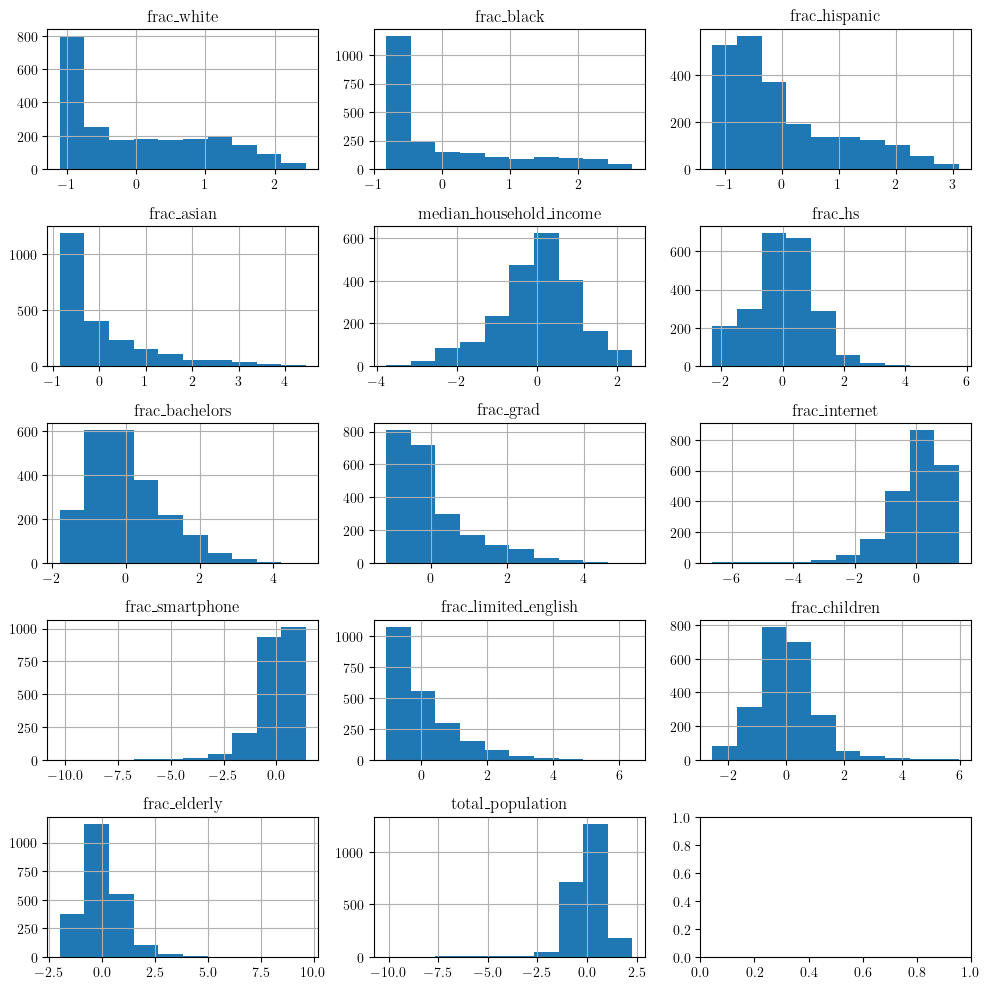

In [27]:
# make small histograms side by side for each var in vars 
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
for i, var in enumerate(vars):
    ax = axs[i//3, i%3]
    analysis_df[var].hist(ax=ax)
    ax.set_title(var)
plt.tight_layout()



In [28]:
analysis_df['any_311_report'] = analysis_df['any_311_report'].astype(int)  


def get_bias_metrics(model, var):
    """
    Extract bias metrics from a fitted statsmodels model for a given variable.
    
    Parameters:
    -----------
    model : statsmodels.discrete.discrete_model.BinaryResultsWrapper
        Fitted logistic regression model
    var : str
        Name of the variable to extract metrics for
        
    Returns:
    --------
    pd.DataFrame
        Single row dataframe with metrics for the variable
    """
    params = model.params
    conf_int = model.conf_int()
    
    return pd.DataFrame({
        'variable': [var],
        'mean': [params[var]],
        'ci_lower': [conf_int.loc[var, 0]],
        'ci_upper': [conf_int.loc[var, 1]],
        'p_value': [model.pvalues[var]],
        'std_err': [model.bse[var]]
    })

def analyze_biases(data, outcome='any_311_report', predictor='p_y', 
                  variables=['frac_white', 'frac_black', 'frac_hispanic', 
                           'frac_asian', 'median_household_income', 'frac_hs', 'frac_bachelors', 'frac_grad', 'frac_internet', 'frac_smartphone', 'frac_limited_english']):
    """
    Analyze biases across multiple variables using logistic regression.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset
    outcome : str
        Name of binary outcome variable
    predictor : str
        Name of main predictor variable
    variables : list
        List of variables to analyze for bias
        
    Returns:
    --------
    pd.DataFrame
        Compiled bias metrics for all variables
    """
    bias_df = pd.DataFrame()
    
    for var in variables:
        # Standardize continuous variables
        data_std = data.copy()
        data_std[var] = (data_std[var] - data_std[var].mean()) / data_std[var].std()
        
        # Fit model with interaction
        formula = f'{outcome} ~ {predictor} + {var}'  # Simplified model without interaction
        try:
            model = sm.Logit.from_formula(formula, data=data_std).fit(
            )
            bias_metrics = get_bias_metrics(model, var)
            bias_df = pd.concat([bias_df, bias_metrics], ignore_index=True)
        except Exception as e:
            print(f"Error fitting model for {var}: {str(e)}")
            
    return bias_df

# Example usage:
# bias_results = analyze_biases(d_income)

bias_results = analyze_biases(analysis_df, outcome='any_311_report', variables=vars)



Optimization terminated successfully.
         Current function value: 0.652252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652978
  

In [29]:
bias_results 

,variable,mean,ci_lower,ci_upper,p_value,std_err
0,frac_white,0.128005,0.042366,0.213644,3.394239e-03,0.043694
1,frac_black,0.026454,-0.059298,0.112205,5.454254e-01,0.043752
2,frac_hispanic,-0.293873,-0.385837,-0.201910,3.772865e-10,0.046921
3,frac_asian,0.090121,0.005302,0.174941,3.729843e-02,0.043276
4,median_household_income,0.163286,0.074290,0.252281,3.230606e-04,0.045407
5,frac_hs,0.068045,-0.018249,0.154339,1.222309e-01,0.044028
6,frac_bachelors,0.051432,-0.034378,0.137242,2.400948e-01,0.043781
7,frac_grad,-0.024547,-0.110950,0.061857,5.776527e-01,0.044084
8,frac_internet,0.059569,-0.028194,0.147333,1.834103e-01,0.044778
9,frac_smartphone,-0.036867,-0.122977,0.049244,4.014036e-01,0.043935


In [30]:
# replace variable names 
mapping = {
    'frac_white': 'Fraction White',
    'frac_black': 'Fraction Black',
    'frac_hispanic': 'Fraction Hispanic',
    'frac_asian': 'Fraction Asian',
    'median_household_income': '$log($Median Household Income$)$',
    'frac_hs': 'Fraction High School Graduates',
    'frac_bachelors': 'Fraction Bachelor\'s Degree',
    'frac_grad': 'Fraction Graduate Degree',
    'frac_internet': 'Fraction Households with Internet',
    'frac_smartphone': 'Fraction Households with Smartphone',
    'frac_limited_english': 'Fraction Households with Limited English',
    'frac_children': r'Fraction Children ($<$ 18 yrs)',
    'frac_elderly': r'Fraction Elderly ( $\leq$ 65 years)',
    'total_population': '$log($Total Population$)$',
}

bias_results['variable'] = bias_results['variable'].map(mapping)
bias_results = bias_results.set_index('variable')

In [31]:
bias_results

,mean,ci_lower,ci_upper,p_value,std_err
variable,,,,,
Fraction White,0.128005,0.042366,0.213644,3.394239e-03,0.043694
Fraction Black,0.026454,-0.059298,0.112205,5.454254e-01,0.043752
Fraction Hispanic,-0.293873,-0.385837,-0.201910,3.772865e-10,0.046921
Fraction Asian,0.090121,0.005302,0.174941,3.729843e-02,0.043276
$log($Median Household Income$)$,0.163286,0.074290,0.252281,3.230606e-04,0.045407
Fraction High School Graduates,0.068045,-0.018249,0.154339,1.222309e-01,0.044028
Fraction Bachelor's Degree,0.051432,-0.034378,0.137242,2.400948e-01,0.043781
Fraction Graduate Degree,-0.024547,-0.110950,0.061857,5.776527e-01,0.044084
Fraction Households with Internet,0.059569,-0.028194,0.147333,1.834103e-01,0.044778


In [32]:
def plot_CIs_covariates(CIs_df, crop_plots=True, ax=None, figsize=(6, 6),
                        covariate_names=None, show=True, ylabel_size=16,
                        xlabel_size=12,
                        color_CIs_by_significance=True, fill_between=False, horizontal_lines=True):
    
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    
    CIs_df = CIs_df.replace({'-':np.nan}).dropna()
    if covariate_names is None: covariate_names = CIs_df.index.values
    
    estimates = CIs_df.loc[covariate_names, 'mean'].values
    UB = CIs_df.loc[covariate_names, 'ci_upper'].values
    LB = CIs_df.loc[covariate_names, 'ci_lower'].values
    CIs = np.vstack([estimates-LB, UB-estimates])

    
    # Get p-values from dataframe
    p_values = CIs_df['p_value'].values

    #Collect colors:
    if color_CIs_by_significance:
        colors = ['red' if ub < 0 else ('blue' if lb > 0 else 'grey')
                 for ub, lb in list(zip(UB, LB))]

        # color in if p-value is significant, else only color the edge 
        mfcs = ['none']*len(estimates)
        for i, p in enumerate(p_values):
            if p < 0.05:
                mfcs[i] = colors[i]
                
    else:
        colors = ['black']*len(estimates)

    #Plot:
    for estimate, name, CI, color, mfc, p_value in zip(estimates[::-1],
                                         covariate_names[::-1],
                                         CIs[::, ::-1].T,
                                         colors[::-1],
                                            mfcs[::-1],
                                         p_values[::-1]):
        _ = ax.errorbar(x=estimate,
                        y=name,
                        xerr=CI.reshape(2,1),
                        ecolor=color,
                        capsize=5,
                        linestyle='None',
                        linewidth=1.5,
                        marker="d",
                        markersize=5,
                        mfc=mfc,
                        mec=color)
        print(f"{name}: {estimate:.2f} ({estimate-CI[0]:.2f}, {estimate+CI[1]:.2f}). Significance: {p_value:.3f}")

    ax.tick_params(axis='y', labelsize=ylabel_size)
    ax.tick_params(axis='x', labelsize=xlabel_size)
    #Grids:
    xlim = ax.get_xlim()
    _ = ax.axvline(0, linestyle='--', color='black', alpha=0.75, zorder=-1, linewidth=1.)

    if fill_between:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), -0.5, 1.5, alpha=.4, color='lightgrey', linewidth=0)
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 6.5, 8.5, alpha=.4, color='lightgrey', linewidth=0)
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 10.5, 14.5, alpha=.4, color='lightgrey', linewidth=0)
    if horizontal_lines:
        for y, c in enumerate(colors[::-1]):
            _ = ax.hlines(y=y, xmin=-3, xmax=3, linestyle='--', linewidth=0.5, alpha=0.5, color='grey')
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(-0.5, len(estimates)-0.5)

    # x axis label
    _ = ax.set_xlabel(r'$\beta_d$', fontsize=16)
            
    if show: plt.show()
        
    return ax

In [33]:
bias_results

,mean,ci_lower,ci_upper,p_value,std_err
variable,,,,,
Fraction White,0.128005,0.042366,0.213644,3.394239e-03,0.043694
Fraction Black,0.026454,-0.059298,0.112205,5.454254e-01,0.043752
Fraction Hispanic,-0.293873,-0.385837,-0.201910,3.772865e-10,0.046921
Fraction Asian,0.090121,0.005302,0.174941,3.729843e-02,0.043276
$log($Median Household Income$)$,0.163286,0.074290,0.252281,3.230606e-04,0.045407
Fraction High School Graduates,0.068045,-0.018249,0.154339,1.222309e-01,0.044028
Fraction Bachelor's Degree,0.051432,-0.034378,0.137242,2.400948e-01,0.043781
Fraction Graduate Degree,-0.024547,-0.110950,0.061857,5.776527e-01,0.044084
Fraction Households with Internet,0.059569,-0.028194,0.147333,1.834103e-01,0.044778


$log($Total Population$)$: 0.08 (-0.01, 0.17). Significance: 0.066
Fraction Elderly ( $\leq$ 65 years): 0.01 (-0.08, 0.10). Significance: 0.825
Fraction Children ($<$ 18 yrs): 0.09 (0.00, 0.17). Significance: 0.044
Fraction Households with Limited English: -0.06 (-0.14, 0.03). Significance: 0.216
Fraction Households with Smartphone: -0.04 (-0.12, 0.05). Significance: 0.401
Fraction Households with Internet: 0.06 (-0.03, 0.15). Significance: 0.183
Fraction Graduate Degree: -0.02 (-0.11, 0.06). Significance: 0.578
Fraction Bachelor's Degree: 0.05 (-0.03, 0.14). Significance: 0.240
Fraction High School Graduates: 0.07 (-0.02, 0.15). Significance: 0.122
$log($Median Household Income$)$: 0.16 (0.07, 0.25). Significance: 0.000
Fraction Asian: 0.09 (0.01, 0.17). Significance: 0.037
Fraction Hispanic: -0.29 (-0.39, -0.20). Significance: 0.000
Fraction Black: 0.03 (-0.06, 0.11). Significance: 0.545
Fraction White: 0.13 (0.04, 0.21). Significance: 0.003


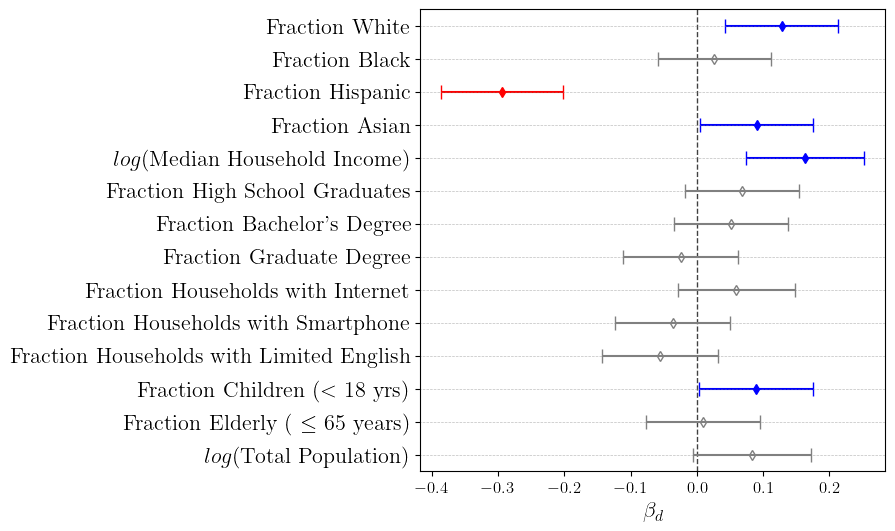

In [34]:
fig = plot_CIs_covariates(bias_results, show=False)
plt.savefig('../../KDD-2025-Flooding-Paper/figures/bias.pdf', bbox_inches='tight', dpi=300)
# save figure 

